## Importações e carregamento de datasets

In [79]:
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, precision_score, accuracy_score, recall_score, f1_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import numpy as np

#importando os 4 datasets
datasets = {
    "Iris": load_iris(),
    "Wine": load_wine(),
    "Breast Cancer": load_breast_cancer(),
    "Digits": load_digits()
}

## Divisão em treino e teste de cada dataset e transformação em DataFrames

In [80]:
dfs = []

#percorre o dicionário de dataframes criado anteriormente
for name, dataset in datasets.items():
    X, y = dataset.data, dataset.target

    #divisão em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

    #normalização
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #transformando os conjunstos de treino e teste em dataframes
    feature_names = dataset.feature_names if hasattr(dataset, 'feature_names') else [f"feature_{i}" for i in range(X.shape[1])]

    train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
    train_df['target'] = y_train

    test_df = pd.DataFrame(X_test_scaled, columns=feature_names)
    test_df['target'] = y_test

    #armazenando os dicionários dentro da lista de dataframes
    dfs.append({
        "name": name,
        "X_train_df": train_df.drop('target', axis=1),
        "y_train": train_df['target'],
        "X_test_df": test_df.drop('target', axis=1),
        "y_test": test_df['target'],
        "full_train_df": train_df,
        "full_test_df": test_df
    })

In [81]:
#olhando o primeiro dataset (iris) após a separação e normalização
dfs[0]['X_train_df']

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-0.900459,-1.220248,-0.441986,-0.136610
1,0.380366,-1.879558,0.402829,0.380294
2,-0.900459,1.636764,-1.286801,-1.170419
3,1.078998,0.318143,1.191323,1.414103
4,-0.201827,-0.560937,0.177545,0.121842
...,...,...,...,...
100,-1.133336,1.197224,-1.343122,-1.428871
101,-0.201827,-1.000477,-0.160381,-0.265837
102,-0.434704,2.515845,-1.343122,-1.299645
103,-0.318266,-0.780707,0.233866,0.121842


## Plotando os gráficos do cotovelo e da silhueta e escolhendo dos valores de k para cada dataset

In [82]:
#plotando os gráficos (cotovelo e silhueta)
def plot_graphs(inertias, silhouettes, dataset_name, k):
    '''
    Função para plotar os gráficos de cotovelo e silhueta.
    Recebe:
    - inertias: lista com os valores de inércia para cada k
    - silhouettes: lista com os valores de silhueta para cada k
    - dataset_name: nome do dataset
    - k: número de clusters definido previamente

    Retorna:
    - Gráficos de cotovelo e silhueta para cada dataset.

    '''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    #gráfico do cotovelo
    ax1.plot(range(2, len(inertias)+2), inertias, 'bx-')
    ax1.set_title(f'Cotovelo - {dataset_name}')

    #gráfico da silhueta
    ax2.plot(range(2, len(silhouettes)+2), silhouettes, 'rx-')
    ax2.set_title(f'Silhueta - {dataset_name}')

    plt.tight_layout()
    plt.show()

In [83]:
#escolhendo o número de clusters para cada dataset
k_values = {
    "Iris": 3,
    "Wine": 3,
    "Breast Cancer": 3,
    "Digits": 8
}

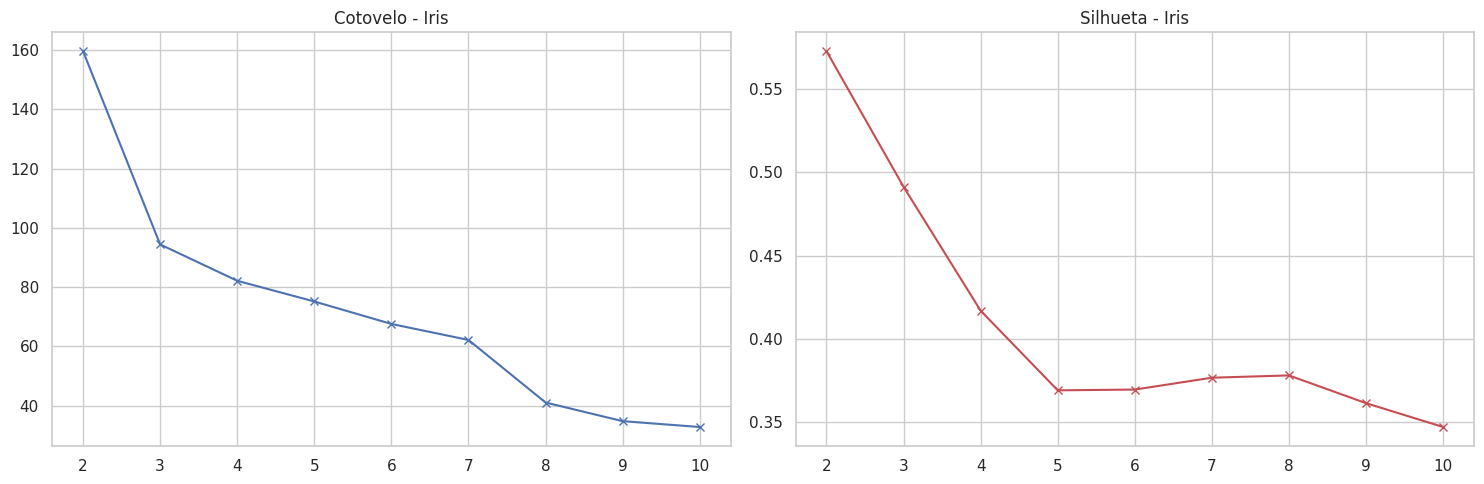

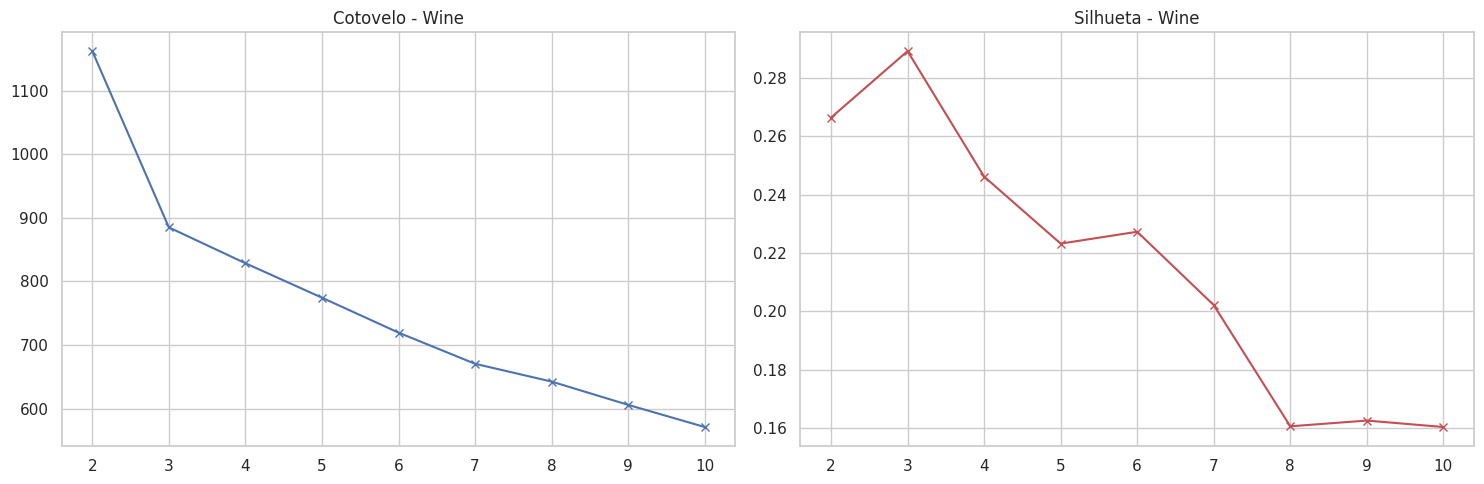

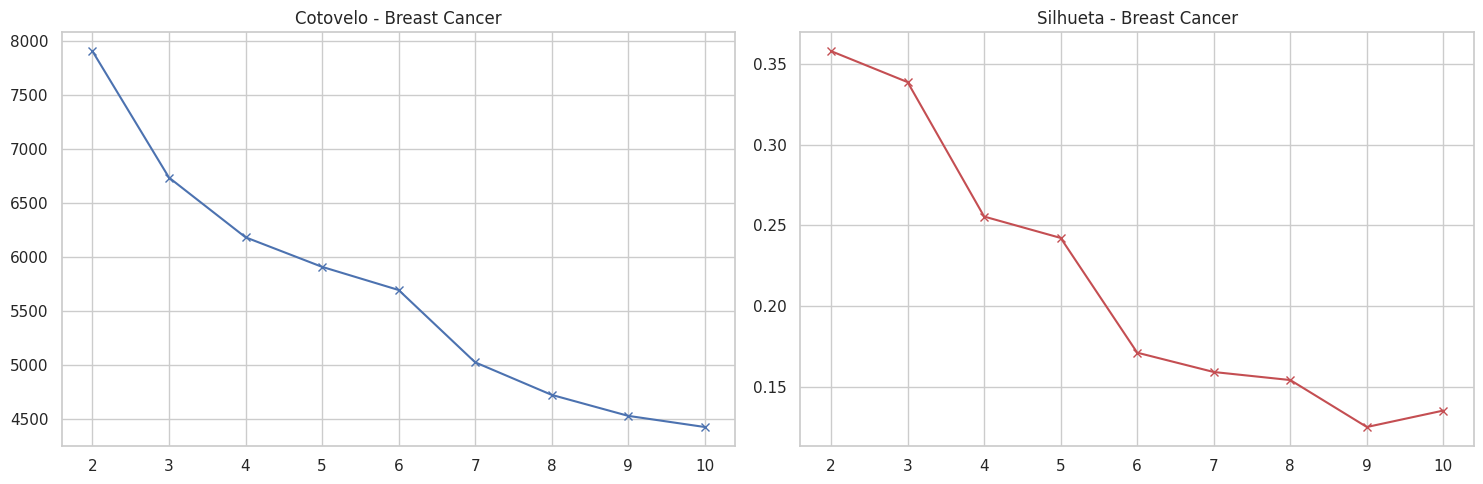

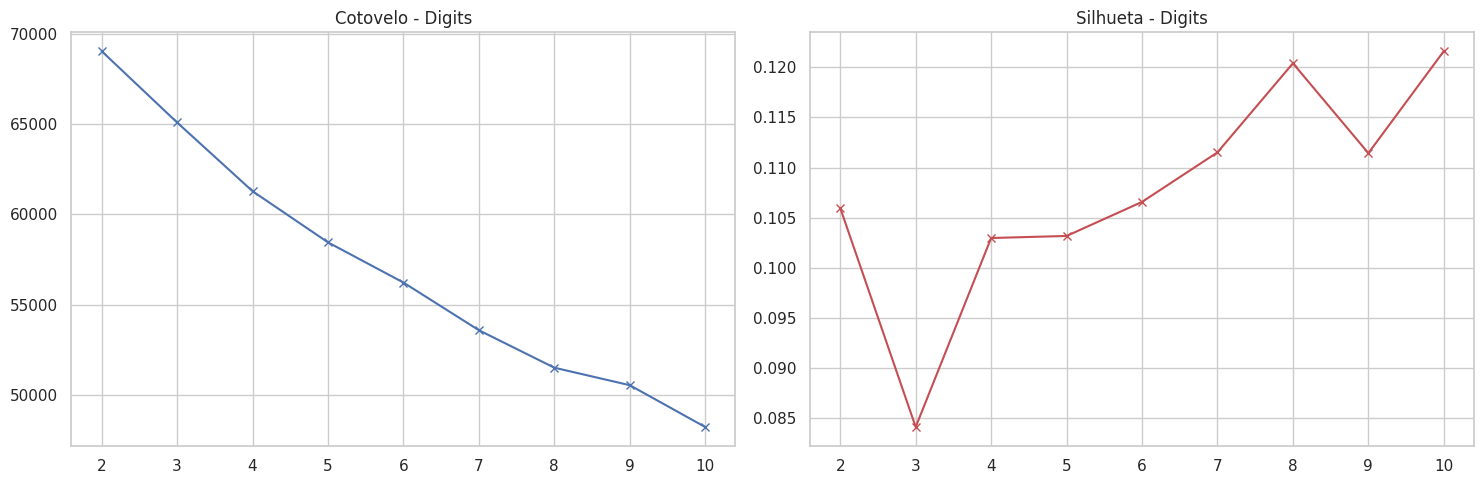

In [84]:
#calculando as inércias e a silhueta de cada dataset
for data in dfs:
    dataset_name = data["name"]
    X_train = data["X_train_df"]

    #pegando os valores de k definidos
    chosen_k = k_values.get(dataset_name, 5)

    #calculando os valores de inércia e silhueta para cada k
    inertias = []
    silhouettes = []
    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(X_train)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X_train, kmeans.labels_))

    #plotando os gráficos
    plot_graphs(inertias, silhouettes, dataset_name, k)

    #armazenando os valores de k
    data["optimal_k"] = chosen_k

## Calculando a distância de cada ponto aos centroides de cada dataset

In [85]:
def calculate_distances(X_df, kmeans_model):
    '''
    Função para calcular as distâncias de cada ponto de dado para cada centroide.
    Recebe:
    - X_df: dataframe com os dados
    - kmeans_model: modelo kmeans já treinado

    Retorna:
    - clusterized_df: dataframe com as distâncias para cada centroide
    '''
    #calcula a distância para os centroides
    distances = kmeans_model.transform(X_df)

    #cria o nome das colunas
    dist_columns = [f'dist_to_centr_{i}' for i in range(kmeans_model.n_clusters)]

    #criando uma cópia de cada dataset e incluindo as colunas com as distâncias
    clusterized_df = X_df.copy()
    for i, col in enumerate(dist_columns):
        clusterized_df[col] = distances[:, i]

    #retorna o df novo
    return clusterized_df

In [86]:
#iterando sobre todos os datasets
for data in dfs:
    #pegando os nomes das features
    feature_names = list(data["X_train_df"].columns)

    #fitando o KMeans
    kmeans = KMeans(n_clusters=data["optimal_k"], random_state=42, n_init='auto')
    kmeans.fit(data["X_train_df"])

    #calculando as distâncias para os centroides e criando os novos dataframes
    data["X_train_clust_df"] = calculate_distances(data["X_train_df"], kmeans)
    data["X_test_clust_df"] = calculate_distances(data["X_test_df"], kmeans)

    #criando os arrays com numpy para usar nos modelos posteriormente
    data["X_train_clust"] = data["X_train_clust_df"].values
    data["X_test_clust"] = data["X_test_clust_df"].values

    #verificando resultados
    print(f"\n{'-'*50}\nDataset: {data['name']} (k={data['optimal_k']})\n{'-'*50}")
    display(data["X_train_clust_df"].head(3))


--------------------------------------------------
Dataset: Iris (k=3)
--------------------------------------------------


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),dist_to_centr_0,dist_to_centr_1,dist_to_centr_2
0,-0.900459,-1.220248,-0.441986,-0.136610,2.473510,3.239191,1.317075
1,0.380366,-1.879558,0.402829,0.380294,3.844388,2.453555,1.127098
2,-0.900459,1.636764,-1.286801,-1.170419,0.836379,4.181404,3.415161



--------------------------------------------------
Dataset: Wine (k=3)
--------------------------------------------------


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,dist_to_centr_0,dist_to_centr_1,dist_to_centr_2
0,0.982686,-0.527640,0.173598,-1.087543,-0.727661,0.491455,0.791460,-0.596717,0.354587,0.255419,0.857462,0.437825,1.863180,5.299486,1.686210,3.937365
1,0.957937,-0.745511,1.255504,0.839386,0.063252,1.131923,1.306553,-0.596717,1.343233,0.297587,1.032095,0.159563,1.749108,5.820619,2.338620,4.511505
2,0.401078,-0.612894,1.777803,-1.235769,0.656436,0.491455,0.707363,-0.170491,-0.425924,-0.166255,0.595512,0.262081,0.429136,4.757301,2.203531,3.684144



--------------------------------------------------
Dataset: Breast Cancer (k=3)
--------------------------------------------------


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,dist_to_centr_0,dist_to_centr_1,dist_to_centr_2
0,-0.709821,-0.258417,-0.637396,-0.711996,1.628430,0.847289,0.166501,0.196420,0.542716,1.347151,...,-0.622613,2.019222,0.186202,0.180187,0.400933,-0.414074,0.445223,5.691028,7.773583,3.957820
1,-0.830331,2.231127,-0.874980,-0.779081,-1.597569,-1.267717,-1.086471,-1.243232,-2.658543,-1.052699,...,-0.779331,-1.747652,-1.229372,-1.258947,-1.692788,-2.095723,-1.323417,7.478493,12.289512,11.491617
2,-1.011097,-0.227270,-1.035172,-0.911780,-1.077779,-1.098096,-0.841650,-0.955767,2.023790,-0.688547,...,-0.909132,-1.515009,-1.165663,-1.078897,-1.364240,-0.354125,-0.886645,4.511751,10.537799,8.244124



--------------------------------------------------
Dataset: Digits (k=8)
--------------------------------------------------


,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_7_6,pixel_7_7,dist_to_centr_0,dist_to_centr_1,dist_to_centr_2,dist_to_centr_3,dist_to_centr_4,dist_to_centr_5,dist_to_centr_6,dist_to_centr_7
0,0.0,-0.336929,-1.092572,0.979494,0.030279,-0.853277,-0.409084,-0.121262,-0.065276,-0.623514,...,-0.505278,-0.18748,8.394640,7.263743,7.138947,8.618126,9.627731,6.083581,6.419004,6.285317
1,0.0,-0.336929,0.392604,0.979494,0.964299,1.791124,1.960587,-0.121262,-0.065276,-0.623514,...,-0.505278,-0.18748,5.190497,7.293165,8.513988,7.670287,10.186048,8.475877,6.735029,8.625811
2,0.0,-0.336929,-0.880404,-0.889536,0.964299,0.204483,-0.409084,-0.121262,-0.065276,-0.623514,...,-0.505278,-0.18748,7.457011,6.955805,7.340197,8.493271,9.252297,8.313113,4.421697,8.988816


# Visualizando os clusters

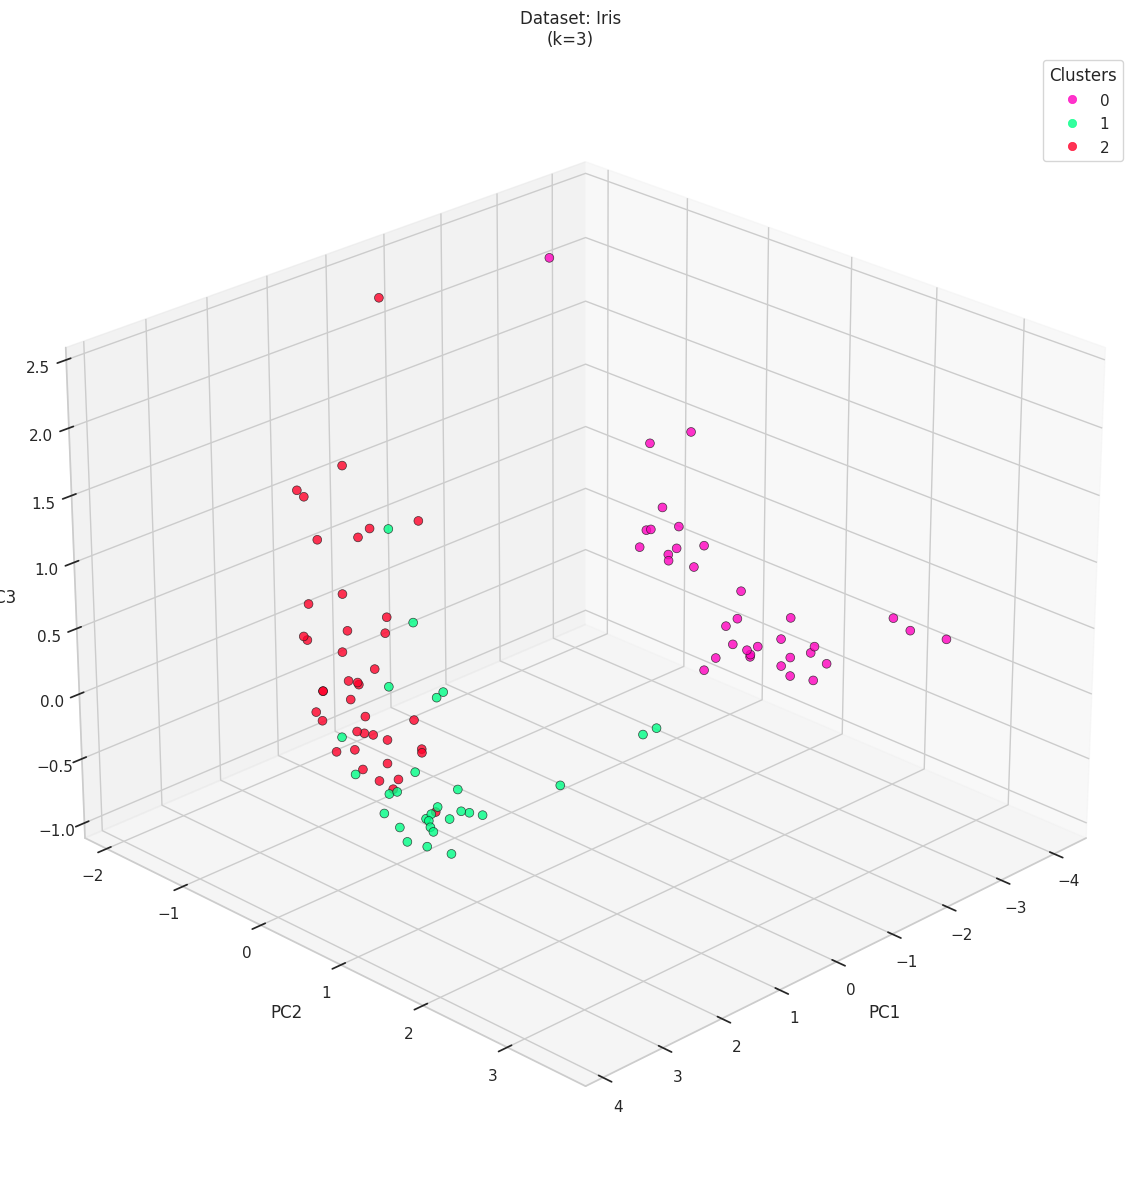

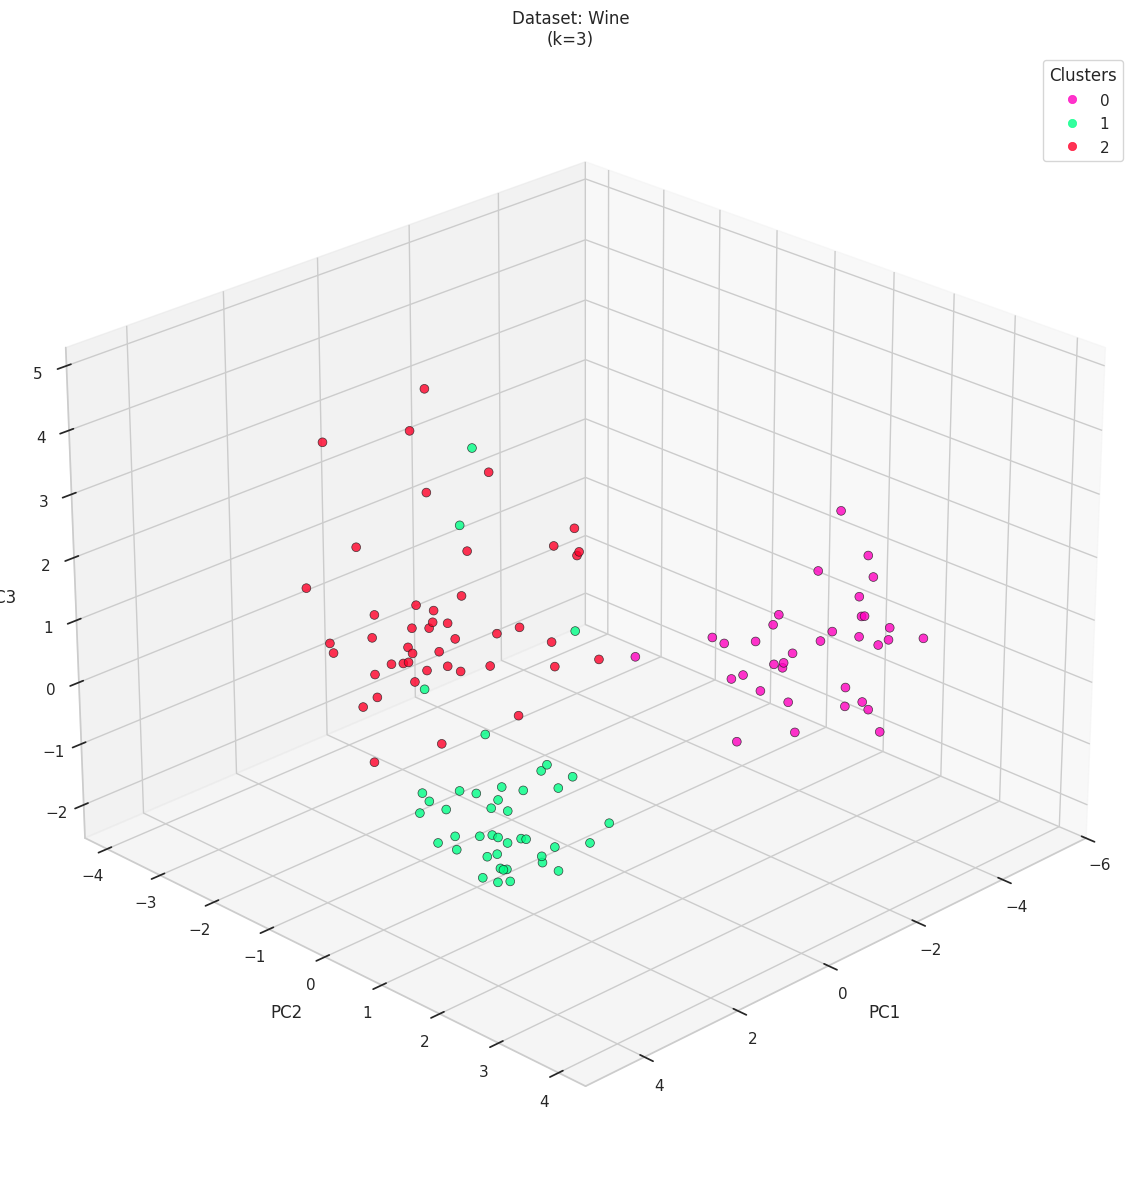

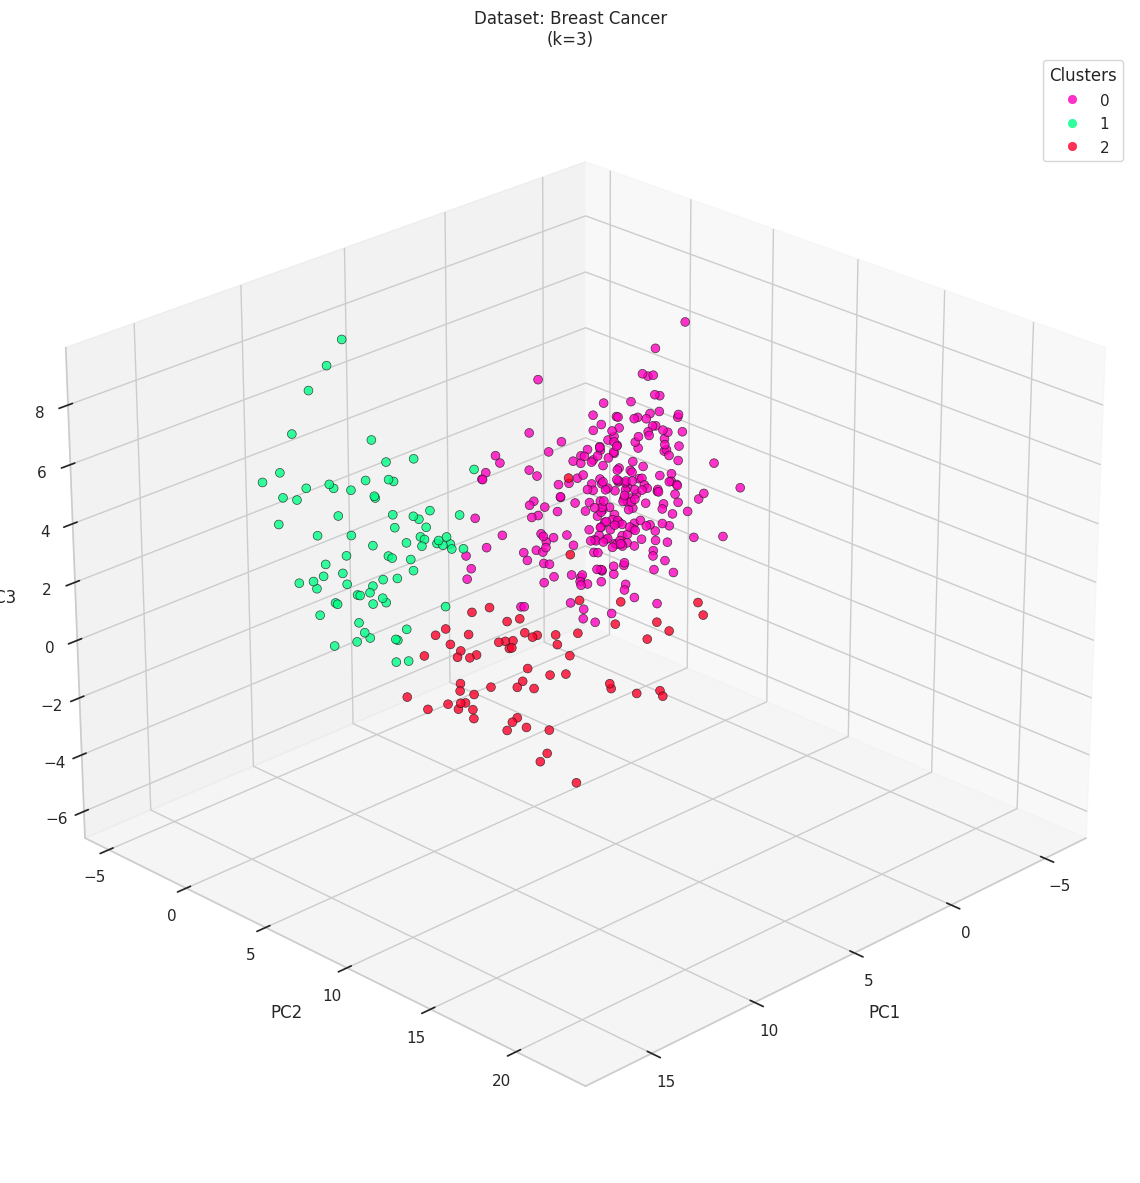

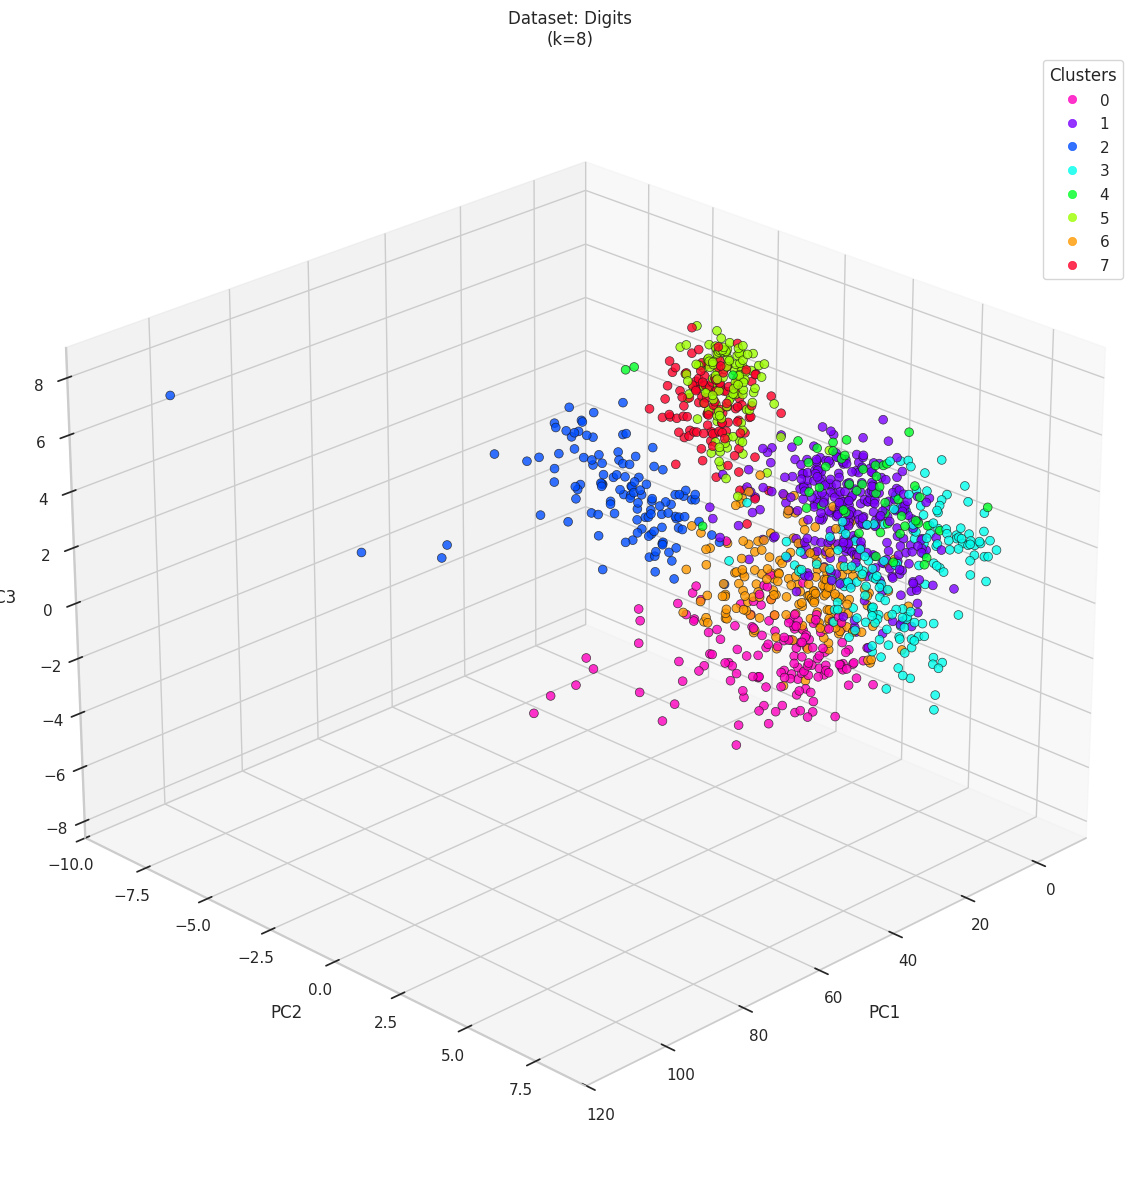

In [109]:
for data in dfs:
    #criando o espaço para os gráficos
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111, projection='3d')

    #aplicando pca para projeção dos dados em 3D
    pca = PCA(n_components=3)
    data["X_train_pca"] = pca.fit_transform(data["X_train_clust"])
    kmeans = KMeans(n_clusters=data["optimal_k"], random_state=42, n_init='auto')
    kmeans.fit(data["X_train_df"])
    data["cluster_labels"] = kmeans.labels_

    #definindo os eixos
    x = data["X_train_pca"][:, 0]
    y = data["X_train_pca"][:, 1]
    z = data["X_train_pca"][:, 2]

    #plotando os dados
    scatter = ax.scatter(x, y, z, c=data["cluster_labels"], cmap="gist_rainbow_r", s=40, alpha=0.8, edgecolor='k', linewidth=0.5)

    #fazendo a legenda
    legend = ax.legend(*scatter.legend_elements(), title="Clusters", loc='upper right')

    #mexendo no ângulo de visualização
    ax.view_init(elev=25, azim=45)

    #título dos gráficos e nomes dos eixos
    ax.set_title(f"Dataset: {data['name']}\n(k={data['optimal_k']})")
    ax.set_xlabel("PC1", labelpad=10)
    ax.set_ylabel("PC2", labelpad=10)
    ax.set_zlabel("PC3", labelpad=10)

    plt.tight_layout()

    plt.show()

## Avaliando o impacto do k nas métricas usando o modelo RandomForest como referência

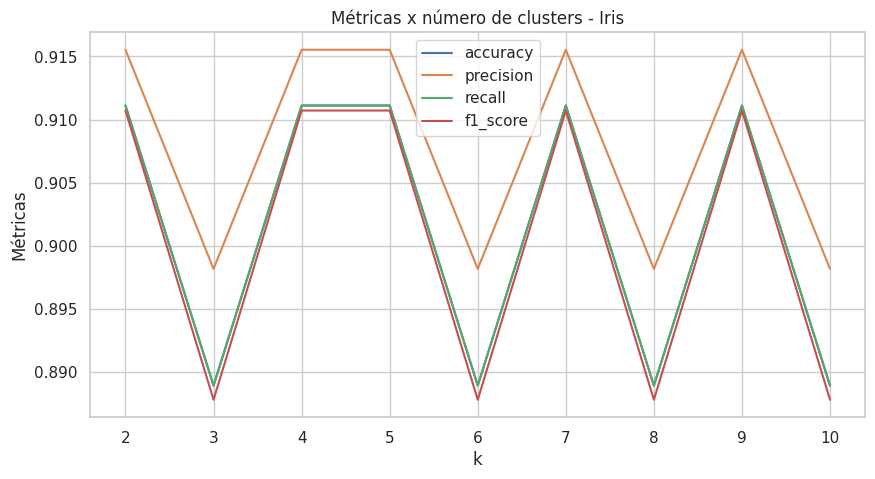

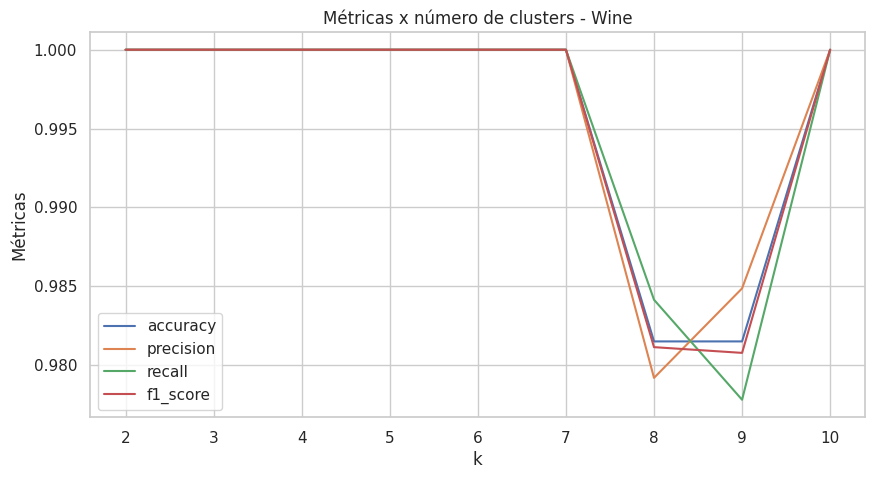

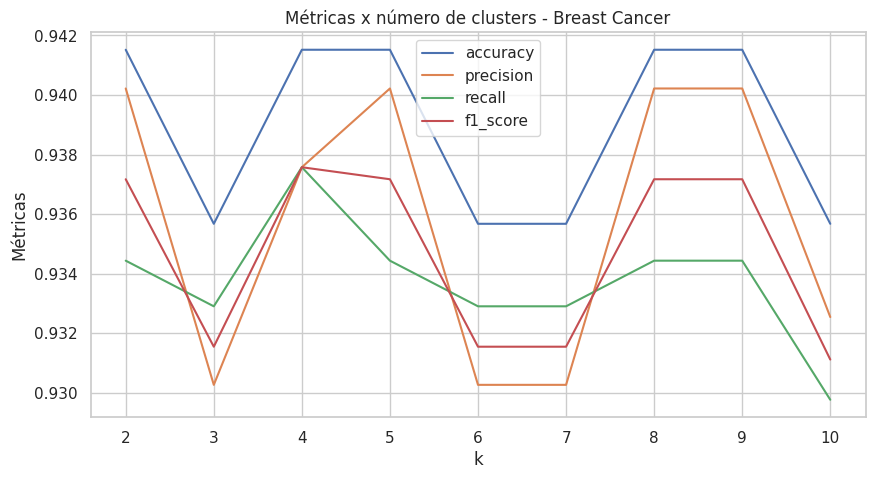

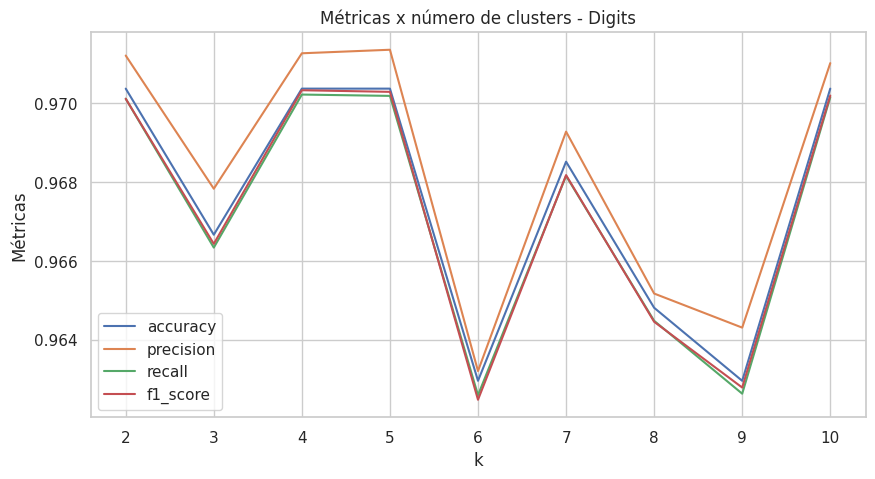

In [88]:
#lista para armazenar os resultados
results = []

#iterando sobre os dataframes
for data in dfs:
    dataset_name = data["name"]
    y_train, y_test = data["y_train"], data["y_test"]
    dataset_results = []

    #clusterizando os dataframes com k indo de 2 a 10
    for k in range(2, 11):
        #Transformando os dados
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(data["X_train_df"])

        #Calculando a distância dos centroides
        X_train_transformed = calculate_distances(data["X_train_df"], kmeans)
        X_test_transformed = calculate_distances(data["X_test_df"], kmeans)

        #Treinando o modelo Random Forest
        rf = RandomForestClassifier(random_state=42)
        rf.fit(X_train_transformed, y_train)
        y_pred = rf.predict(X_test_transformed)

        #Guardando os resultados
        metrics = {
            'Dataset': dataset_name,
            'k_clusters': k,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='macro'),
            'recall': recall_score(y_test, y_pred, average='macro'),
            'f1_score': f1_score(y_test, y_pred, average='macro')
        }
        dataset_results.append(metrics)

    #Plotando os gráficos
    plt.figure(figsize=(10, 5))
    plt.title(f'Métricas x número de clusters - {dataset_name}')
    plt.xlabel('k')
    plt.ylabel('Métricas')

    k_values = [res['k_clusters'] for res in dataset_results]
    plt.plot(k_values, [res['accuracy'] for res in dataset_results], label='accuracy')
    plt.plot(k_values, [res['precision'] for res in dataset_results], label='precision')
    plt.plot(k_values, [res['recall'] for res in dataset_results], label='recall')
    plt.plot(k_values, [res['f1_score'] for res in dataset_results], label='f1_score')

    plt.legend()
    plt.show()

    results.extend(dataset_results)

results_df = pd.DataFrame(results)

In [89]:
summary = results_df.groupby(['Dataset', 'k_clusters']).mean(numeric_only=True)
summary

accuracy  precision    recall  f1_score
Dataset       k_clusters                                         
Breast Cancer 2           0.941520   0.940219  0.934433  0.937169
              3           0.935673   0.930261  0.932900  0.931543
              4           0.941520   0.937573  0.937573  0.937573
              5           0.941520   0.940219  0.934433  0.937169
              6           0.935673   0.930261  0.932900  0.931543
              7           0.935673   0.930261  0.932900  0.931543
              8           0.941520   0.940219  0.934433  0.937169
              9           0.941520   0.940219  0.934433  0.937169
              10          0.935673   0.932540  0.929761  0.931112
Digits        2           0.970370   0.971209  0.970115  0.970114
              3           0.966667   0.967833  0.966340  0.966435
              4           0.970370   0.971267  0.970220  0.970330
              5           0.970370   0.971356  0.970186  0.970289
              6           0.962963   0.963211  0.962599  0.962483
              7           0.968519   0.969280  0.968159  0.968178
              8           0.964815   0.965175  0.964485  0.964460
              9           0.962963   0.964311  0.962637  0.962792
              10          0.970370   0.971017  0.970153  0.970194
Iris          2           0.911111   0.915535  0.911111  0.910714
              3           0.888889   0.898148  0.888889  0.887767
              4           0.911111   0.915535  0.911111  0.910714
              5           0.911111   0.915535  0.911111  0.910714
              6           0.888889   0.898148  0.888889  0.887767
              7           0.911111   0.915535  0.911111  0.910714
              8           0.888889   0.898148  0.888889  0.887767
              9           0.911111   0.915535  0.911111  0.910714
              10          0.888889   0.898148  0.888889  0.887767
Wine          2           1.000000   1.000000  1.000000  1.000000
              3           1.000000   1.000000  1.000000  1.000000
              4           1.000000   1.000000  1.000000  1.000000
              5           1.000000   1.000000  1.000000  1.000000
              6           1.000000   1.000000  1.000000  1.000000
              7           1.000000   1.000000  1.000000  1.000000
              8           0.981481   0.979167  0.984127  0.981117
              9           0.981481   0.984848  0.977778  0.980754
              10          1.000000   1.000000  1.000000  1.000000

## Treinando modelos de classificação com GridSearch e calculando métricas

In [90]:
#criando a lista de resultados para armazenar os resultados
results = []

#dicionário de modelos a serem treinados
models = {
    "SVM Linear": (SVC(probability=True, kernel='linear'), {"C": [0.01, 0.1, 1, 10]}),
    "SVM RBF": (SVC(probability=True, kernel='rbf'), {"C": [0.01, 0.1, 1, 10], "gamma": ["scale", "auto"]}),
    "SVM Poli grau 2": (SVC(probability=True, kernel='poly', degree=2), {"C": [0.01, 0.1, 1, 10]}),
    "SVM Poli grau 3": (SVC(probability=True, kernel='poly', degree=3), {"C": [0.01, 0.1, 1, 10]}),
    "Random Forest": (RandomForestClassifier(), {"n_estimators": [10, 50, 100], "max_depth": [None, 5, 10], "criterion": ['gini', 'entropy']})
}

In [91]:
#percorrendo a lista de dataframes
for data in dfs:
    #selecionando os dataframes de treino e teste de acordo com o tipo de dado original (normal vs. clusterizado)
    for data_type in ["original", "clusterized"]:
        X_train = data["X_train_df"] if data_type == "original" else data["X_train_clust"]
        X_test = data["X_test_df"] if data_type == "original" else data["X_test_clust"]
        y_train, y_test = data["y_train"], data["y_test"]

        #percorrendo o dicinário de modelos
        for model_name, (model, params) in models.items():
            #aplicando o gridsearch
            gs = GridSearchCV(model, params, cv=5, scoring='f1_macro', n_jobs=-1)
            gs.fit(X_train, y_train)

            y_pred = gs.predict(X_test)
            y_proba = gs.predict_proba(X_test)[:, 1] if len(np.unique(y_test)) == 2 else gs.predict_proba(X_test) #condicional para tratar classificações binárias E multiclasses

            #guardando os melhores parâmetros
            best_params = gs.best_params_

            #criando dicionário de métricas
            metrics = {
                "Dataset": data["name"],
                "Data Type": data_type,
                "Model": model_name,
                "Best Parameters": str(best_params),
                "Accuracy": accuracy_score(y_test, y_pred),
                "Precision": precision_score(y_test, y_pred, average='macro'),
                "Recall": recall_score(y_test, y_pred, average='macro'),
                "F1-Score": f1_score(y_test, y_pred, average='macro'),
                "AUC-ROC": roc_auc_score(y_test, y_proba, multi_class='ovo') if len(np.unique(y_test)) > 2 else roc_auc_score(y_test, y_proba) #também adaptando para tanto classificação binária quanto multiclasse
            }

            #acrescentando as métricas à lista de resultados
            results.append(metrics)

#exibindo um dataframe com os melhores parâmetros para cada modelo, por dataset
results_df = pd.DataFrame(results)
results_df

,Dataset,Data Type,Model,Best Parameters,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,Iris,original,SVM Linear,{'C': 0.1},0.911111,0.915535,0.911111,0.910714,0.989630
1,Iris,original,SVM RBF,"{'C': 1, 'gamma': 'scale'}",0.933333,0.934524,0.933333,0.933259,0.995556
2,Iris,original,SVM Poli grau 2,{'C': 10},0.866667,0.871658,0.866667,0.860577,0.974074
3,Iris,original,SVM Poli grau 3,{'C': 10},0.911111,0.929825,0.911111,0.909502,0.995556
4,Iris,original,Random Forest,"{'criterion': 'entropy', 'max_depth': 5, 'n_es...",0.955556,0.960784,0.955556,0.955357,0.997037
5,Iris,clusterized,SVM Linear,{'C': 0.1},0.866667,0.881978,0.866667,0.864253,0.992593
6,Iris,clusterized,SVM RBF,"{'C': 1, 'gamma': 'scale'}",0.866667,0.881978,0.866667,0.864253,0.992593
7,Iris,clusterized,SVM Poli grau 2,{'C': 10},0.933333,0.934524,0.933333,0.933259,0.995556
8,Iris,clusterized,SVM Poli grau 3,{'C': 10},0.933333,0.934524,0.933333,0.933259,0.994074
9,Iris,clusterized,Random Forest,"{'criterion': 'gini', 'max_depth': 10, 'n_esti...",0.911111,0.915535,0.911111,0.910714,0.992593


In [92]:
#Resumo organizado por dataset e modelo
summary = results_df.groupby(["Dataset", "Data Type", "Model"]).mean(numeric_only=True)

summary

Accuracy  Precision    Recall  \
Dataset       Data Type   Model                                            
Breast Cancer clusterized Random Forest    0.941520   0.940219  0.934433   
                          SVM Linear       0.959064   0.964740  0.948452   
                          SVM Poli grau 2  0.982456   0.982804  0.979702   
                          SVM Poli grau 3  0.976608   0.978174  0.971890   
                          SVM RBF          0.964912   0.969144  0.956265   
              original    Random Forest    0.947368   0.948137  0.939106   
                          SVM Linear       0.959064   0.964740  0.948452   
                          SVM Poli grau 2  0.836257   0.839043  0.806367   
                          SVM Poli grau 3  0.953216   0.965217  0.937500   
                          SVM RBF          0.976608   0.975029  0.975029   
Digits        clusterized Random Forest    0.968519   0.968867  0.968297   
                          SVM Linear       0.979630   0.981185  0.979375   
                          SVM Poli grau 2  0.981481   0.982759  0.981158   
                          SVM Poli grau 3  0.975926   0.977349  0.975460   
                          SVM RBF          0.975926   0.976515  0.975707   
              original    Random Forest    0.966667   0.967095  0.966586   
                          SVM Linear       0.979630   0.980774  0.979337   
                          SVM Poli grau 2  0.975926   0.976702  0.975813   
                          SVM Poli grau 3  0.990741   0.990771  0.990703   
                          SVM RBF          0.983333   0.983795  0.983152   
Iris          clusterized Random Forest    0.911111   0.915535  0.911111   
                          SVM Linear       0.866667   0.881978  0.866667   
                          SVM Poli grau 2  0.933333   0.934524  0.933333   
                          SVM Poli grau 3  0.933333   0.934524  0.933333   
                          SVM RBF          0.866667   0.881978  0.866667   
              original    Random Forest    0.955556   0.960784  0.955556   
                          SVM Linear       0.911111   0.915535  0.911111   
                          SVM Poli grau 2  0.866667   0.871658  0.866667   
                          SVM Poli grau 3  0.911111   0.929825  0.911111   
                          SVM RBF          0.933333   0.934524  0.933333   
Wine          clusterized Random Forest    1.000000   1.000000  1.000000   
                          SVM Linear       0.981481   0.979167  0.984127   
                          SVM Poli grau 2  0.981481   0.979167  0.984127   
                          SVM Poli grau 3  0.981481   0.979167  0.984127   
                          SVM RBF          1.000000   1.000000  1.000000   
              original    Random Forest    1.000000   1.000000  1.000000   
                          SVM Linear       1.000000   1.000000  1.000000   
                          SVM Poli grau 2  0.907407   0.906481  0.911640   
                          SVM Poli grau 3  0.944444   0.952153  0.939683   
                          SVM RBF          0.981481   0.984848  0.977778   

                                           F1-Score   AUC-ROC  
Dataset       Data Type   Model                                
Breast Cancer clusterized Random Forest    0.937169  0.992991  
                          SVM Linear       0.955563  0.996349  
                          SVM Poli grau 2  0.981212  0.995473  
                          SVM Poli grau 3  0.974868  0.996933  
                          SVM RBF          0.962045  0.996203  
              original    Random Forest    0.943263  0.990070  
                          SVM Linear       0.955563  0.994670  
                          SVM Poli grau 2  0.817363  0.879819  
                          SVM Poli grau 3  0.948649  0.997225  
                          SVM RBF          0.975029  0.996495  
Digits        clusterized Random Forest    0.968306  0.998696  
                  

## Plotando os resultados finais

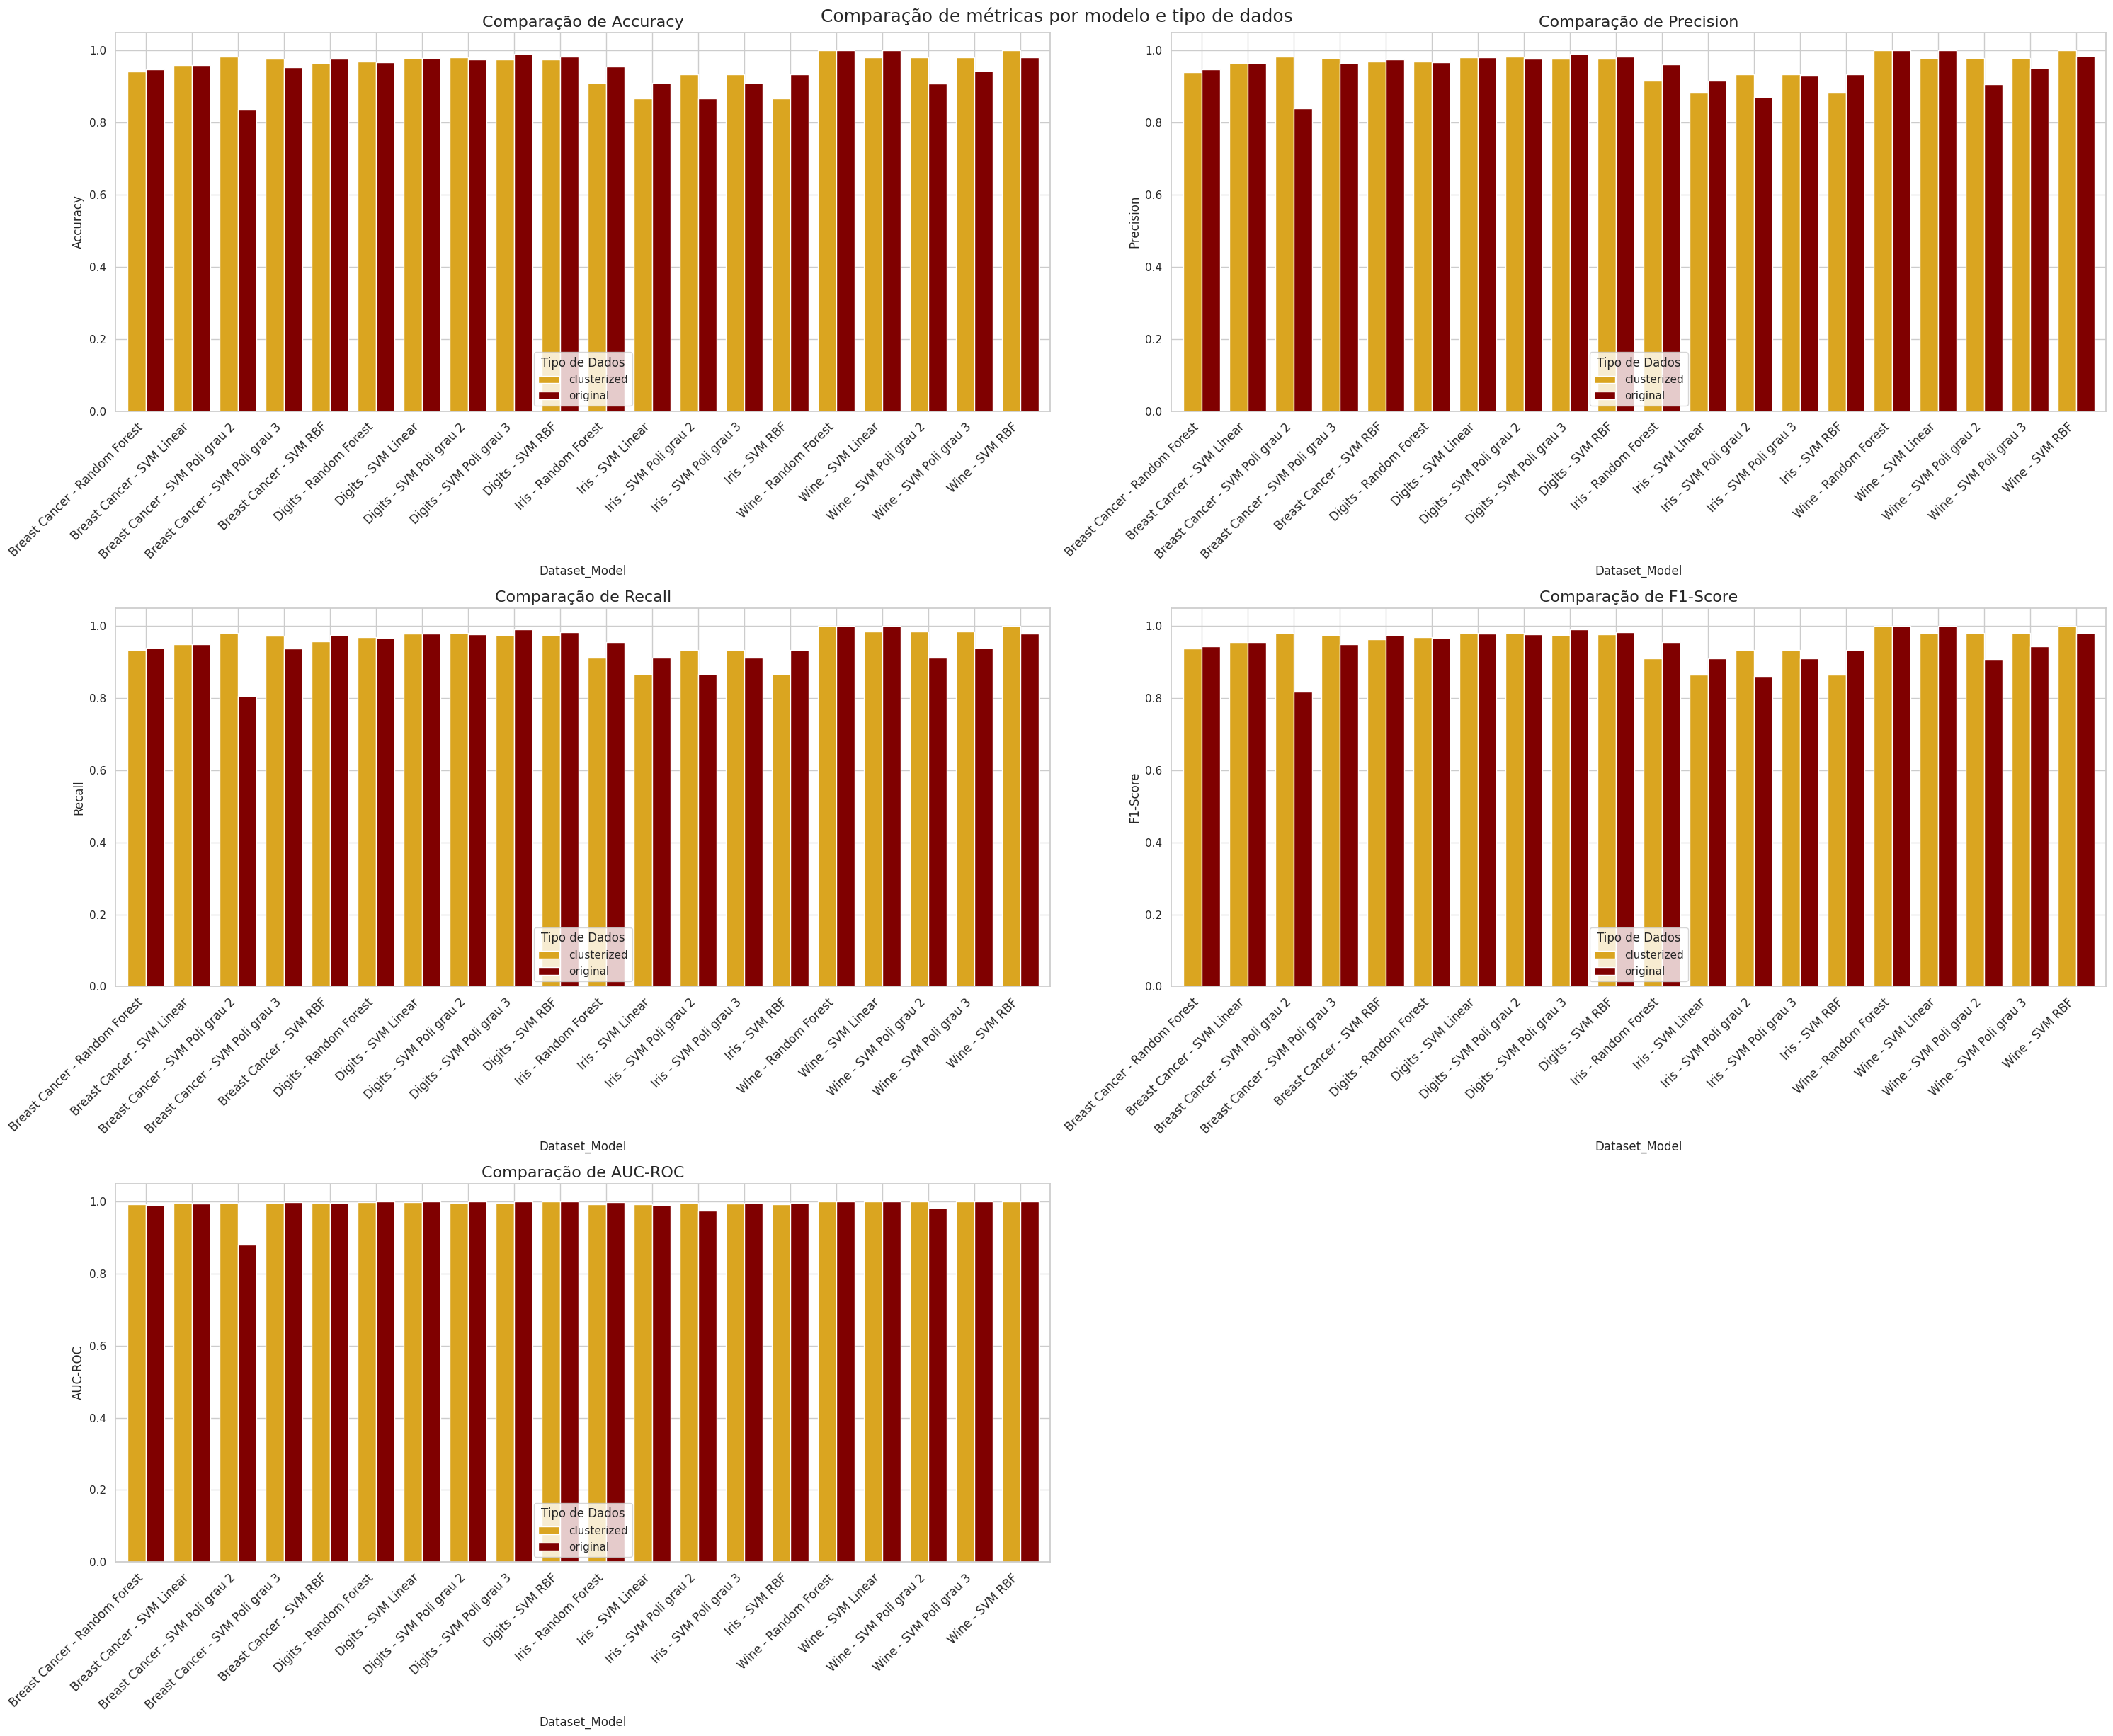

In [93]:
#configurações gerais dos gráficos
sns.set(style="whitegrid")
plt.figure(figsize=(30, 25))
plt.suptitle('Comparação de métricas por modelo e tipo de dados', fontsize=18)

#juntando os modelos aos datasets correspondentes
results_df['Dataset_Model'] = results_df['Dataset'] + ' - ' + results_df['Model']

#métricas para plotagem
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']

#criando um gráfico para cada métrica
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(3, 2, i)

    #criando a pivot table com os valores das métricas para cada modelo em cada dataset
    metric_df = results_df.pivot_table(index='Dataset_Model',
                                     columns='Data Type',
                                     values=metric)

    #plotando o gráfico de barras
    metric_df.plot(kind='bar', ax=plt.gca(), color=['goldenrod', 'maroon'], width=0.8)

    plt.title(f'Comparação de {metric}', fontsize=16)
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.legend(title='Tipo de Dados')
    plt.tight_layout()

plt.show()

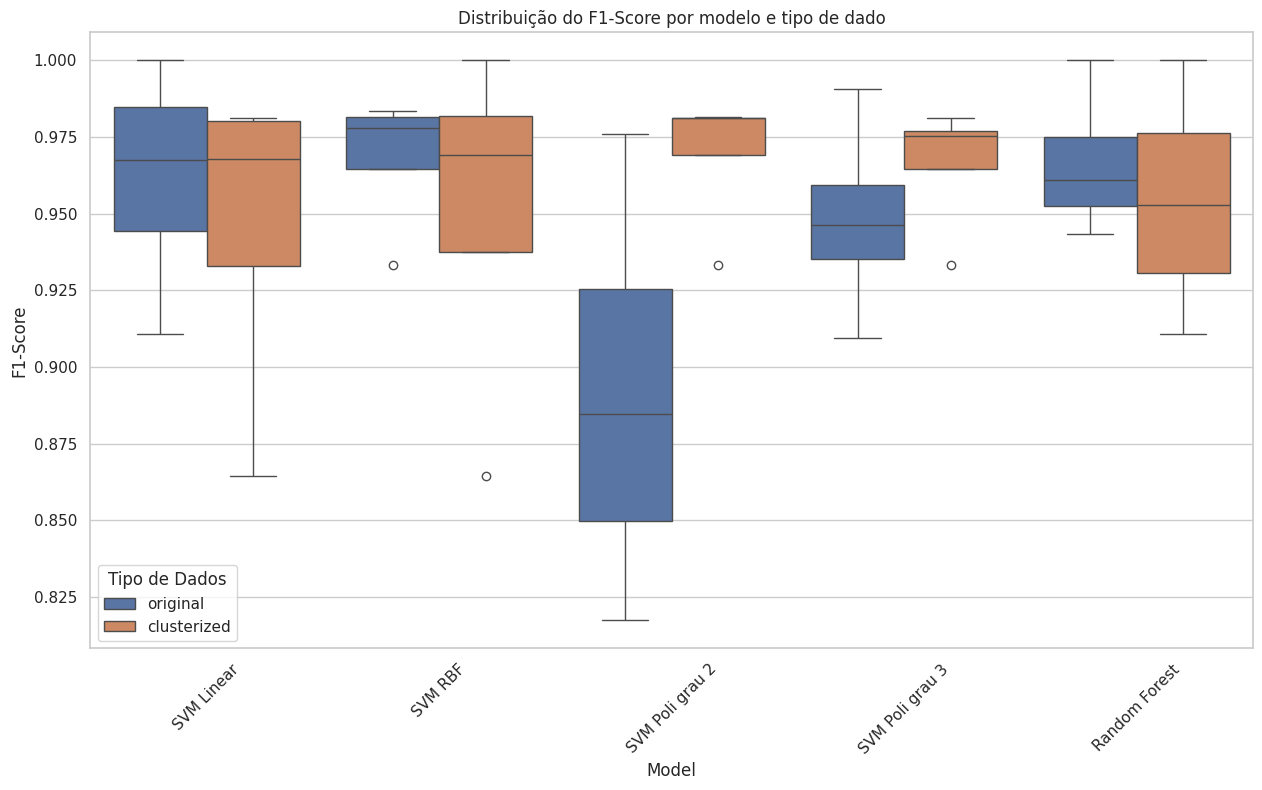

In [94]:
#análise do F1-Score por tipo de modelo e de dado
plt.figure(figsize=(15, 8))
sns.boxplot(x='Model', y='F1-Score', hue='Data Type', data=results_df)
plt.title('Distribuição do F1-Score por modelo e tipo de dado')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Dados')
plt.show()

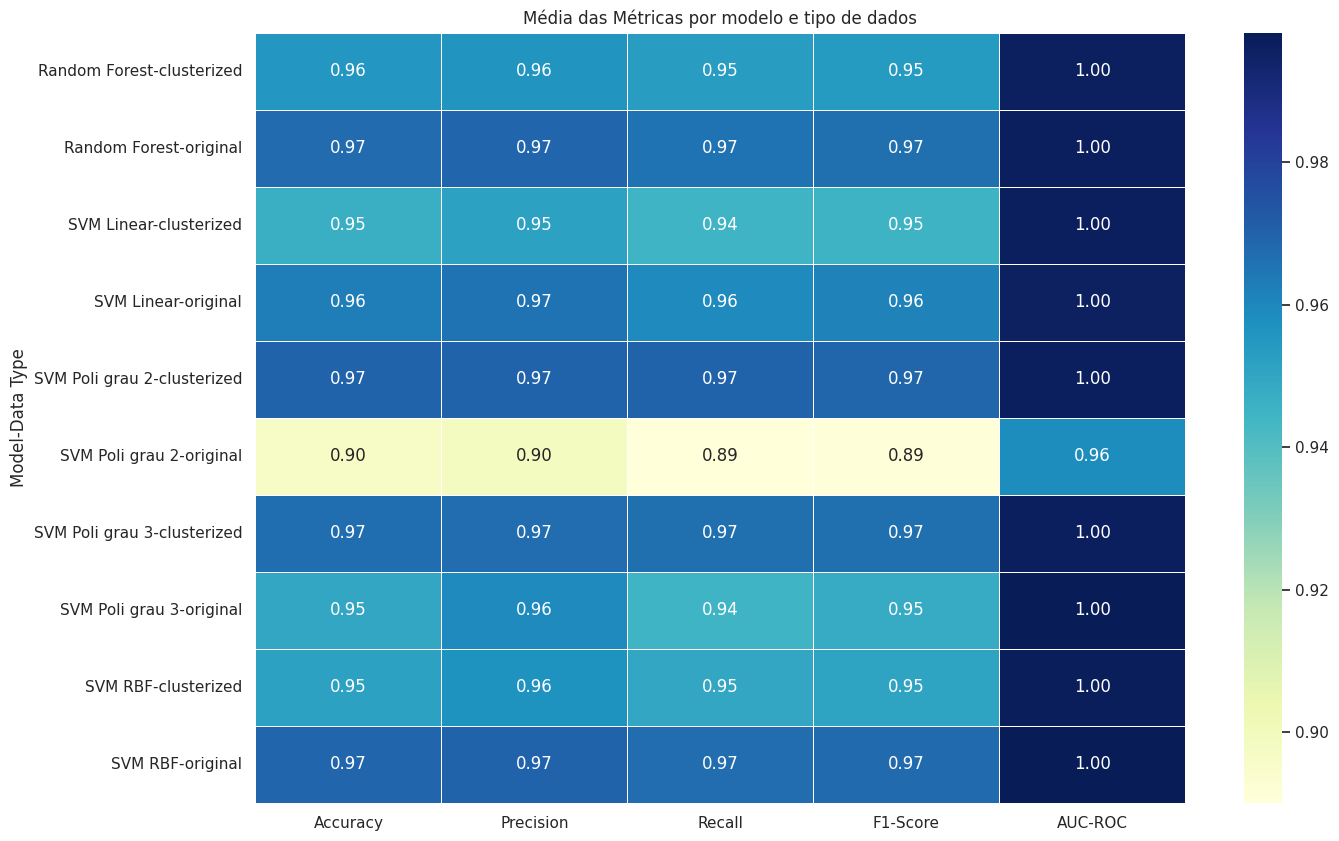

In [95]:
#gráfico de calor para ver as médias das métricas dos modelos separados por tipo de dado
plt.figure(figsize=(15, 10))
heatmap_data = results_df.groupby(['Model', 'Data Type'])[metrics_to_plot].mean()
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5)
plt.title('Média das Métricas por modelo e tipo de dados')
plt.show()

## Conclusões

Como era de se esperar, visto que estamos trabalhando com toy datasets em que praticamente nenhum tipo de pré-processamento precisa ser realizado, todos os modelos tiveram desempenhos excelentes (>90%) em todas as métricas avaliadas. A curva ROC não serviu muito como métrica nestes dados, pois estão praticamente maximizadas em todos os casos. O tamanho do impacto da clusterização dos dados variou de acordo com o dataset, com o ganho mais notável sendo no dataset de Breast Cancer com o modelo SVM polinomial grau 2, indo de aproximadamente 90% para 97%. Ainda neste modelo em específico, observamos o fato de que a clusterização serviu para deixar o modelo com o F1-Score mais consistente em todos os datasets, reduzindo seu desvio padrão quando comparado com os dados não clusterizados. O mesmo ocorreu com o modelo SVM polinomial grau 3, embora em menor escala. Entretanto, no caso do SVM RBF, a clusterização fez o inverso: deixou o modelo com um F1-Score menos consistente.

No geral, a clusterização ajudou a otimização dos modelos, ainda que de forma pequena, com a ressalva no dataset Iris, onde os modelos Random Forest, SVM linear e RBF tiveram melhor desempenho nos dados não-clusterizados. O Wine dataset parece ser o dataset em que os modelos entenderam melhor, chegando a alcançar a perfeição em todas as métricas (100%) com o Random Forest e com o SVM RBF quando os dados estavam clusterizados e com o SVM linear quando com os dados originais.

Com relação ao número de clusters, para a minha surpresa, os k ótimos não corresponderam exatamente ao número esperado de rótulos dos datasets. Ao invés de serem Iris: 3, Wine: 4, Breast Cancer: 2 e Digits: 10, ao analisar graficamente o melhor k usando uma média entre o método do cotovelo e da silhueta, obtivemos os seguintes valores: Iris: 3, Wine: 3, Breast Cancer: 3 e Digits: 8. O que é interessante de se notar: embora temos 10 dígitos diferentes que aglomeramos em apenas 8 clusters, alguns modelos ainda conseguiram predizer, com quase perfeição, os rótulos prévios. Entretanto, esta escolha de k foi quase que arbitrária, visto que o gráfico para este dataset não possui um cotovelo propriamente dito; é quase uma linha reta. O mesmo caso se aplica ao Breast Cancer dataset: embora só temos dois rótulos (desfecho sim/não), o melhor número de clusters parece ser 3.

Analisando a performance de um único modelo (Random Forest) sobre os datasets com números variados de clusters, vimos que as métricas seguem as tendências umas das outras: quando há acréscimo em uma métrica, todas as outras também aumentam, acompanhando o traçado umas das outras. O mais curioso foi o desempenho no dataset Wine: de 2 a 7 clusters, o modelo tem o mesmo desempenho perfeito em todas as métricas, e este só começa a cair a partir de 8 clusters.